# Préparation des données pour construire un modèle

Lino Galiana  
2024-09-23

Ce chapitre utilise le jeu de données présenté dans l’[introduction
de cette partie](index.qmd) :
les données de vote aux élections présidentielles américaines de 2020 au niveau des comtés
croisées à des variables socio-démographiques.
Le code de consitution de la base de données
est disponible [sur `Github`](https://github.com/linogaliana/python-datascientist/blob/main/content/modelisation/get_data.py).
L’exercice 1 permet, à ceux qui le désirent, d’essayer de le reconstituer pas à pas.

Le guide utilisateur de `Scikit` est une référence précieuse,
à consulter régulièrement. La partie sur le *preprocessing* est
disponible [ici](https://scikit-learn.org/stable/modules/preprocessing.html).

L’objectif de ce chapitre est de présenter quelques éléments de
préparation des données. Il s’agit d’une étape fondamentale, à ne
pas négliger. Les modèles reposent sur certaines hypothèses, généralement
relatives à la distribution théorique des variables qui y sont intégrées.

Il est nécessaire de faire correspondre la distribution empirique
à ces hypothèses, ce qui implique un travail de restructuration des données.
Celui-ci permettra d’avoir des résultats de modélisation plus pertinents.
Nous verrons dans le chapitre sur les *pipelines* comment industrialiser
ces étapes de *preprocessing* afin de se simplifier la vie pour appliquer
un modèle sur un jeu de données différent de celui sur lequel il a été estimé.

<div class="alert alert-warning" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-lightbulb"></i> <code>Scikit-Learn</code> </h3>

`scikit-learn` est aujourd’hui la librairie de référence dans l’écosystème du
*Machine Learning*. Il s’agit d’une librairie qui, malgré les très nombreuses
méthodes implémentées, présente l’avantage d’être un point d’entrée unifié.
Cet aspect unifié est l’une des raisons du succès précoce de celle-ci. `R` n’a
bénéficié que plus récemment d’une librairie unifiée,
à savoir [`tidymodels`](https://www.tidymodels.org/).

Une autre raison du succès de `scikit` est son approche opérationnelle : la mise
en production de modèles développés via les *pipelines* `scikit` est peu coûteuse.
Un [chapitre spécial de ce cours](../../pipeline-scikit) est dédié aux *pipelines*.
Avec Romain Avouac, nous proposons un [cours plus avancé](https://ensae-reproductibilite.github.io/website/)
en dernière année d’ENSAE où nous présentons certains enjeux relatifs
à la mise en production de modèles développés avec `scikit`.

Le coeur de l’équipe de développement de `scikit-learn` est situé
à l’[Inria](https://www.inria.fr/fr) 🇫🇷.
Pour découvrir la richesse de l’écosystème `scikit`, il
est recommandé de suivre le
[`MOOC scikit`](https://www.fun-mooc.fr/fr/cours/machine-learning-python-scikit-learn/),
développé dans le cadre de l’initiative [`Inria Academy`](https://www.inria.fr/fr/mooc-scikit-learn).

</div>

Les *packages* suivants sont nécessaires pour importer et visualiser
les données d’élection :

In [1]:
!pip install --upgrade xlrd #colab bug verson xlrd
!pip install geopandas

Dans ce chapitre, nous allons nous focaliser sur la préparation
des données à faire en amont du travail de modélisation.
Cette étape est indispensable pour s’assurer de la cohérence
entre les données et les hypothèses de modélisation mais aussi
pour produire des analyses valides scientifiquement.

La démarche générale que nous adopterons dans ce chapitre, et
qui sera ensuite raffinée dans les prochains chapitres,
est la suivante :

![](https://minio.lab.sspcloud.fr/lgaliana/generative-art/pythonds/scikit_predict.png)

C’est l’approche classique du *machine learning*. On découpe
l’ensemble des données disponibles en deux parties, échantillons
d’apprentissage et de validation. Le premier sert à entraîner
un modèle et la qualité des prédictions de celui-ci est
évaluée sur le deuxième pour limiter
le biais de surapprentissage. Le chapitre suivant approfondira
cette question de l’évaluation des modèles. A ce stade de notre
progression, on se concentrera dans ce chapitre
sur la question des données. La librairie `Scikit` est non seulement
particulièrement
pratique parce qu’elle propose énormément d’algorithmes de *machine learning*
mais aussi parce qu’elle facilite la préparation des données en amont,
ce qui est l’objet de ce chapitre.

Néanmoins, avant de se concentrer sur la préparation des données, nous
allons passer un peu de temps à explorer la structure des données
à partir de laquelle nous désirons construire une modélisation. Ceci
est indispensable afin de comprendre la nature de celles-ci et choisir
une modélisation adéquate.

# 1. Construction de la base de données

Les sources de données étant diverses, le code qui construit la base finale est directement fourni.
Le travail de construction d’une base unique
est un peu fastidieux mais il s’agit d’un bon exercice, que vous pouvez tenter,
pour [réviser `Pandas`](../../content/manipulation/02a_pandas_tutorial.qmd) :

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 1 : Importer les données des élections US</h3>

**Cet exercice est OPTIONNEL**

1.  Télécharger et importer le shapefile [depuis ce lien](https://www2.census.gov/geo/tiger/GENZ2019/shp/cb_2019_02_sldl_500k.zip)
2.  Exclure les Etats suivants : “02”, “69”, “66”, “78”, “60”, “72”, “15”
3.  Importer les résultats des élections depuis [ce lien](https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-20/master/2020_US_County_Level_Presidential_Results.csv)
4.  Importer les bases disponibles sur le site de l’USDA en faisant attention à renommer les variables de code FIPS de manière identique
    dans les 4 bases
5.  *Merger* ces 4 bases dans une base unique de caractéristiques socioéconomiques
6.  *Merger* aux données électorales à partir du code FIPS
7.  *Merger* au shapefile à partir du code FIPS. Faire attention aux 0 à gauche dans certains codes. Il est
    recommandé d’utiliser la méthode `str.lstrip` pour les retirer
8.  Importer les données des élections 2000 à 2016 à partir du [MIT Election Lab](https://electionlab.mit.edu/data)?
    Les données peuvent être directement requêtées depuis l’url
    <https://dataverse.harvard.edu/api/access/datafile/3641280?gbrecs=false>
9.  Créer une variable `share` comptabilisant la part des votes pour chaque candidat.
    Ne garder que les colonnes `"year", "FIPS", "party", "candidatevotes", "share"`
10. Faire une conversion `long` to `wide` avec la méthode `pivot_table` pour garder une ligne
    par comté x année avec en colonnes les résultats de chaque candidat dans cet état.
11. Merger à partir du code FIPS au reste de la base.

</div>

Si vous ne faites pas l’exercice 1, pensez à charger les données en executant la fonction `get_data.py` :

In [2]:
import requests

url = "https://raw.githubusercontent.com/linogaliana/python-datascientist/main/content/modelisation/get_data.py"
r = requests.get(url, allow_redirects=True)
open("getdata.py", "wb").write(r.content)

import getdata

votes = getdata.create_votes_dataframes()


Ce code introduit une base nommée `votes` dans l’environnement. Il s’agit d’une
base rassemblant les différentes sources. Elle a l’aspect
suivant :

In [3]:
votes.head(3)


3 rows × 383 columns

La carte choroplèthe suivante permet de visualiser rapidement les résultats
(l’Alaska et Hawaï ont été exclus).

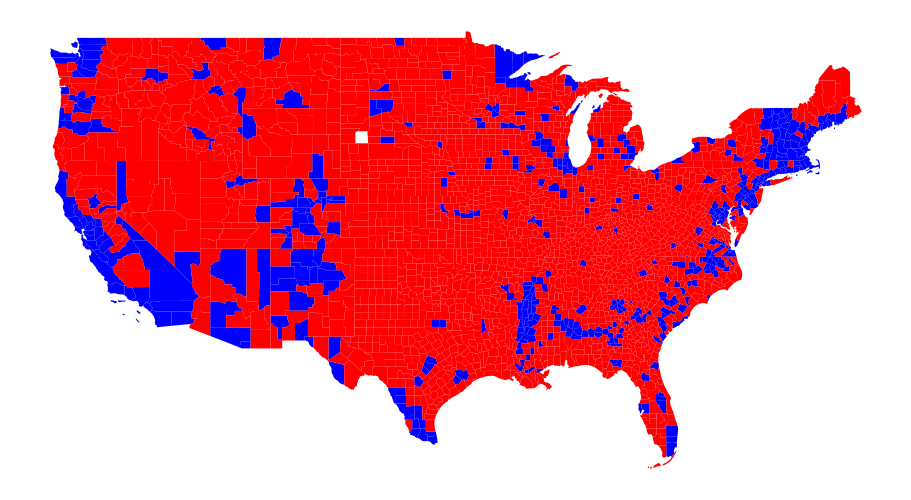

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# republican : red, democrat : blue
color_dict = {"republican": "#FF0000", "democrats": "#0000FF"}

fig, ax = plt.subplots(figsize=(12, 12))
grouped = votes.groupby("winner")
for key, group in grouped:
    group.plot(ax=ax, column="winner", label=key, color=color_dict[key])
plt.axis("off")


Les cartes choroplèthes peuvent donner une impression fallacieuse
ce qui explique que
ce type de carte a servi
de justification pour contester les résultats du vote.
En effet, un biais
connu des représentations choroplèthes est qu’elles donnent une importance
visuelle excessive aux grands espaces. Or, ceux-ci sont souvent des espaces
peu denses et influencent donc moins la variable d’intérêt (en l’occurrence
le taux de vote en faveur des républicains/démocrates). Une représentation à
privilégier pour ce type de phénomènes est les
ronds proportionnels (voir Insee (2018), *“Le piège territorial en cartographie”*).

Le [GIF “Land does not vote, people do”](https://www.core77.com/posts/90771/A-Great-Example-of-Better-Data-Visualization-This-Voting-Map-GIF)
qui avait eu un certain succès en 2020 propose un autre mode de visualisation.
La carte originale a été construite avec `JavaScript`. Cependant,
on dispose avec `Python` de plusieurs outils
pour répliquer, à faible coût, cette carte
grâce à
l’une des surcouches à `JavaScript` vues dans la partie [visualisation](#visualisation).

En l’occurrence, on peut utiliser `Plotly` pour tenir compte de la population
et faire une carte en ronds proportionnels.
Le code suivant permet de construire une carte adaptée :

In [5]:
import plotly
import plotly.graph_objects as go
import pandas as pd
import geopandas as gpd


centroids = votes.copy()
centroids.geometry = centroids.centroid
centroids["size"] = (
    centroids["CENSUS_2010_POP"] / 10000
)  # to get reasonable plotable number

color_dict = {"republican": "#FF0000", "democrats": "#0000FF"}
centroids["winner"] = np.where(
    centroids["votes_gop"] > centroids["votes_dem"], "republican", "democrats"
)


centroids["lon"] = centroids["geometry"].x
centroids["lat"] = centroids["geometry"].y
centroids = pd.DataFrame(
    centroids[["county_name", "lon", "lat", "winner", "CENSUS_2010_POP", "state_name"]]
)
groups = centroids.groupby("winner")

df = centroids.copy()

df["color"] = df["winner"].replace(color_dict)
df["size"] = df["CENSUS_2010_POP"] / 6000
df["text"] = (
    df["CENSUS_2010_POP"]
    .astype(int)
    .apply(lambda x: "<br>Population: {:,} people".format(x))
)
df["hover"] = (
    df["county_name"].astype(str)
    + df["state_name"].apply(lambda x: " ({}) ".format(x))
    + df["text"]
)

fig_plotly = go.Figure(
    data=go.Scattergeo(
        locationmode="USA-states",
        lon=df["lon"],
        lat=df["lat"],
        text=df["hover"],
        mode="markers",
        marker_color=df["color"],
        marker_size=df["size"],
        hoverinfo="text",
    )
)

fig_plotly.update_traces(
    marker={
        "opacity": 0.5,
        "line_color": "rgb(40,40,40)",
        "line_width": 0.5,
        "sizemode": "area",
    }
)

fig_plotly.update_layout(
    title_text='Reproduction of the "Acres don\'t vote, people do" map <br>(Click legend to toggle traces)',
    showlegend=True,
    geo={"scope": "usa", "landcolor": "rgb(217, 217, 217)"},
)


In [6]:
fig_plotly.show()


Les cercles proportionnels permettent ainsi à l’oeil de se concentrer sur les
zones les plus denses et non sur les grands espaces. Cette fois, on voit bien
que le vote démocrate est majoritaire, ce que cachait l’aplat de couleur.

# 2. Explorer la structure des données

La première étape nécessaire à suivre avant de se lancer dans la modélisation
est de déterminer les variables à inclure dans le modèle.

Les fonctionnalités de `Pandas` sont, à ce niveau, suffisantes pour explorer des structures simples.
Néanmoins, lorsqu’on est face à un jeu de données présentant de
nombreuses variables explicatives (*features* en machine learning, *covariates* en économétrie),
il est souvent judicieux d’avoir une première étape de sélection de variables,
ce que nous verrons par la suite dans la [partie dédiée](4_featureselection.qmd).

Avant d’être en mesure de sélectionner le meilleur ensemble de variables explicatives,
nous allons en prendre un nombre restreint et arbitraire.
La première tâche est de représenter les relations entre les données,
notamment la relation des variables explicatives
à la variable dépendante (le score du parti républicain)
ainsi que les relations entre les variables explicatives.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 2 : Regarder les corrélations entre les variables</h3>

**Cet exercice est OPTIONNEL**

1.  Créer un DataFrame `df2` plus petit avec les variables `winner`, `votes_gop`, `Unemployment_rate_2019`,
    `Median_Household_Income_2019`,
    `Percent of adults with less than a high school diploma, 2015-19`,
    `Percent of adults with a bachelor's degree or higher, 2015-19`
2.  Représenter grâce à un graphique la matrice de corrélation. Vous pouvez utiliser le *package* `seaborn` et sa fonction `heatmap`.
3.  Représenter une matrice de nuages de points des variables de la base `df2` avec `pd.plotting.scatter_matrix`
4.  (optionnel) Refaire ces figures avec `Plotly` qui offre également la possibilité de faire une matrice de corrélation.

</div>

In [8]:
# 1. Créer le data.frame df2.
df2 = votes.set_index("GEOID").loc[
    :,
    [
        "winner",
        "votes_gop",
        "Unemployment_rate_2019",
        "Median_Household_Income_2019",
        "Percent of adults with less than a high school diploma, 2015-19",
        "Percent of adults with a bachelor's degree or higher, 2015-19",
    ],
]


In [9]:
# 2. Matrice de corrélation graphique
g1 = sns.heatmap(
    df2.drop("winner", axis=1).corr(), cmap="coolwarm", annot=True, fmt=".2f"
)

# Construction directement avec pandas également possible
g2 = (
    df2.drop("winner", axis=1)
    .corr()
    .style.background_gradient(cmap="coolwarm")
    .format("{:.2f}")
)


La matrice construite avec `seaborn` (question 2) aura l’aspect suivant :

<Axes: >

Alors que celle construite directement avec `corr` de `Pandas`
ressemblera plutôt à ce tableau :

Le nuage de point obtenu à l’issue de la question 3 ressemblera à :

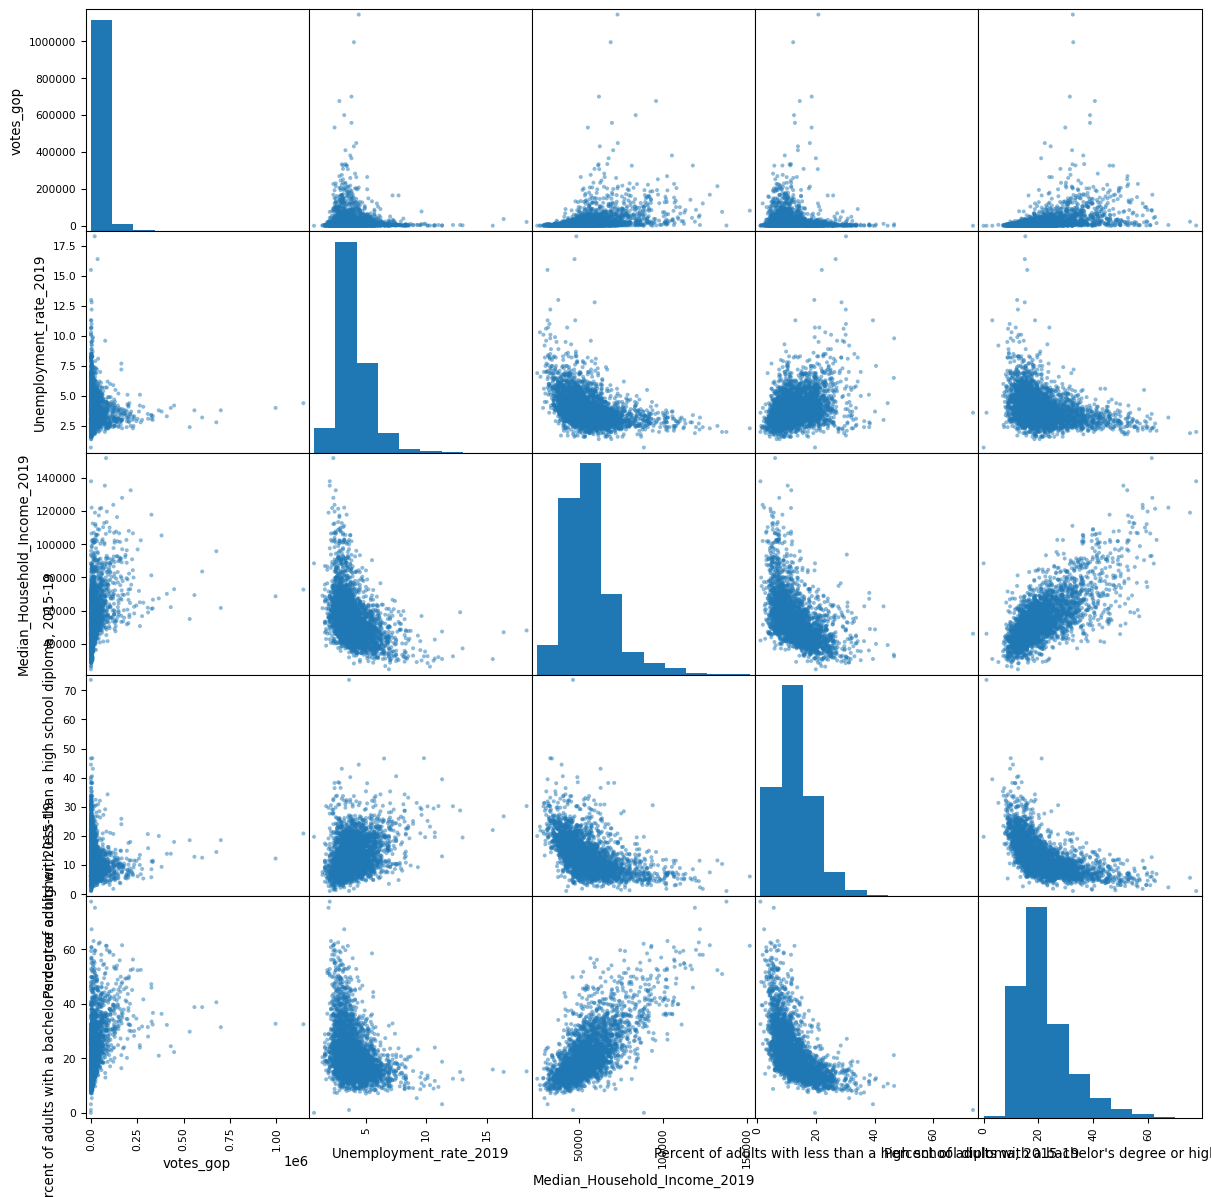

In [12]:
# 3. Matrice de nuages de points
ax = pd.plotting.scatter_matrix(df2, figsize=(15, 15))


array([[<Axes: xlabel='votes_gop', ylabel='votes_gop'>,
        <Axes: xlabel='Unemployment_rate_2019', ylabel='votes_gop'>,
        <Axes: xlabel='Median_Household_Income_2019', ylabel='votes_gop'>,
        <Axes: xlabel='Percent of adults with less than a high school diploma, 2015-19', ylabel='votes_gop'>,
        <Axes: xlabel="Percent of adults with a bachelor's degree or higher, 2015-19", ylabel='votes_gop'>],
       [<Axes: xlabel='votes_gop', ylabel='Unemployment_rate_2019'>,
        <Axes: xlabel='Unemployment_rate_2019', ylabel='Unemployment_rate_2019'>,
        <Axes: xlabel='Median_Household_Income_2019', ylabel='Unemployment_rate_2019'>,
        <Axes: xlabel='Percent of adults with less than a high school diploma, 2015-19', ylabel='Unemployment_rate_2019'>,
        <Axes: xlabel="Percent of adults with a bachelor's degree or higher, 2015-19", ylabel='Unemployment_rate_2019'>],
       [<Axes: xlabel='votes_gop', ylabel='Median_Household_Income_2019'>,
        <Axes: xlabel=

Le résultat de la question 4 devrait, quant à lui,
ressembler au graphique suivant :

In [14]:
# 4. Matrice de corrélation avec plotly
import plotly
import plotly.express as px

htmlsnip2 = px.scatter_matrix(df2)
htmlsnip2.update_traces(diagonal_visible=False)
htmlsnip2.show()


# 3. Transformer les données

Les différences d’échelle ou de distribution entre les variables peuvent
diverger des hypothèses sous-jacentes dans les modèles.

Par exemple, dans le cadre
de la régression linéaire, les variables catégorielles ne sont pas traitées à la même
enseigne que les variables ayant valeur dans $\mathbb{R}$. Une variable
discrète (prenant un nombre fini de valeurs) devra être transformée en suite de
variables 0/1 par rapport à une modalité de référence pour être en adéquation
avec les hypothèses de la régression linéaire.
On appelle ce type de transformation
*one-hot encoding*, sur laquelle nous reviendrons. Il s’agit d’une transformation,
parmi d’autres, disponibles dans `scikit` pour mettre en adéquation un jeu de
données et des hypothèses mathématiques.

L’ensemble de ces tâches s’appelle le *preprocessing*. L’un des intérêts
d’utiliser `Scikit` est qu’on peut considérer qu’une tâche de *preprocessing*
est, en fait, une tâche d’apprentissage. En effet, le *preprocessing*
consiste à apprendre des paramètres d’une structure
de données (par exemple estimer moyennes et variances pour les retrancher à chaque
observation) et on peut très bien appliquer ces paramètres
à des observations qui n’ont pas servi à construire
ceux-ci. Ainsi, en gardant en tête l’approche générale avec `Scikit`,

![](https://minio.lab.sspcloud.fr/lgaliana/generative-art/pythonds/scikit_predict.png)

nous allons voir deux processus très classiques de *preprocessing* :

1.  La **standardisation** transforme des données pour que la distribution empirique suive une loi $\mathcal{N}(0,1)$.

2.  La **normalisation** transforme les données de manière à obtenir une norme ($\mathcal{l}_1$ ou $\mathcal{l}_2$) unitaire. Autrement dit, avec la norme adéquate, la somme des éléments est égale à 1.

<div class="alert alert-danger" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-triangle-exclamation"></i> Warning</h3>

Pour un statisticien,
le terme *normalization* dans le vocable `Scikit` peut avoir un sens contre-intuitif.
On s’attendrait à ce que la normalisation consiste à transformer une variable de manière à ce que $X \sim \mathcal{N}(0,1)$.
C’est, en fait, la **standardisation** en `Scikit` qui fait cela.

</div>

## 3.1 Standardisation

La standardisation consiste à transformer des données pour que la distribution empirique suive une loi $\mathcal{N}(0,1)$. Pour être performants, la plupart des modèles de *machine learning* nécessitent souvent d’avoir des données dans cette distribution.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 3: Standardisation</h3>

1.  Standardiser la variable `Median_Household_Income_2019` (ne pas écraser les valeurs !) et regarder l’histogramme avant/après normalisation.

*Note : On obtient bien une distribution centrée à zéro et on pourrait vérifier que la variance empirique soit bien égale à 1. On pourrait aussi vérifier que ceci est vrai également quand on transforme plusieurs colonnes à la fois.*

1.  Créer `scaler`, un `Transformer` que vous construisez sur les 1000 premières lignes de votre DataFrame `df2` à l’exception de la variable à expliquer `winner`. Vérifier la moyenne et l’écart-type de chaque colonne sur ces mêmes observations.

*Note : Les paramètres qui seront utilisés pour une standardisation ultérieure sont stockés dans les attributs `.mean_` et `.scale_`*

On peut voir ces attributs comme des paramètres entraînés sur un certain jeu de
données et qu’on peut réutiliser sur un autre, à condition que les
dimensions coïncident.

1.  Appliquer `scaler` sur les autres lignes du DataFrame et comparer les distributions obtenues de la variable `Median_Household_Income_2019`.

*Note : Une fois appliqués à un autre `DataFrame`, on peut remarquer que la distribution n’est pas exactement centrée-réduite dans le `DataFrame` sur lequel les paramètres n’ont pas été estimés. C’est normal, l’échantillon initial n’était pas aléatoire, les moyennes et variances de cet échantillon n’ont pas de raison de coïncider avec les moments de l’échantillon complet.*

</div>

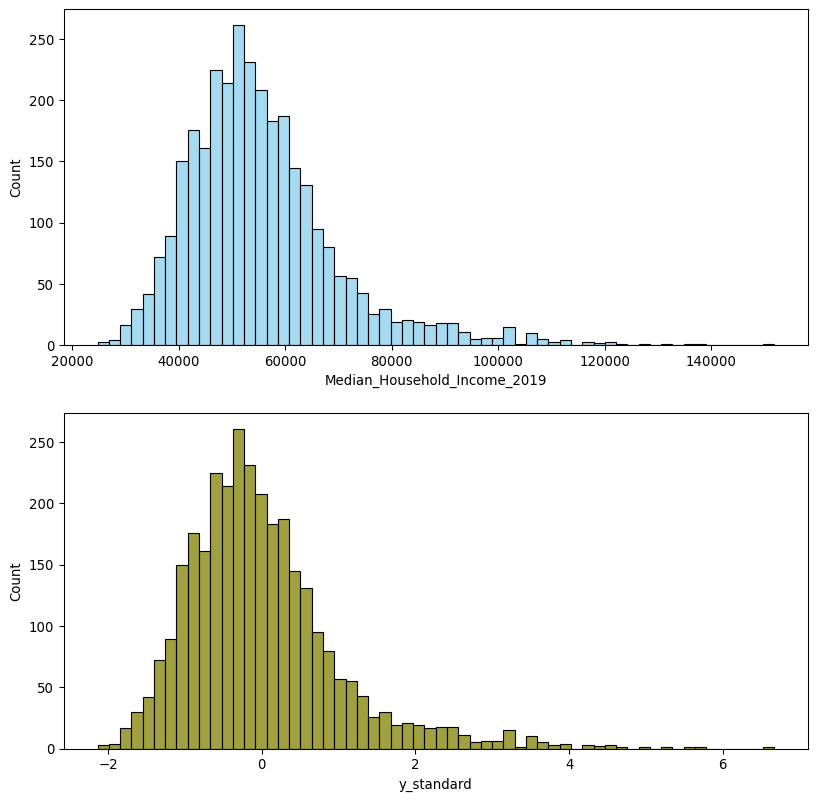

Moyenne de chaque variable sur 1000 premières observations avant :  [ 1.73616500e+04  3.84530000e+00  5.51891150e+04  1.29669150e+01
  2.15813433e+01 -2.73468885e-02]
Ecart-type de chaque variable sur 1000 premières observations avant :  [3.28113703e+04 1.28903822e+00 1.33256197e+04 6.45536365e+00
 9.41139584e+00 9.23129044e-01]
Moyenne de chaque variable sur 1000 premières observations après :  [-3.37507799e-17  2.66453526e-17  1.58095759e-16  1.42108547e-17
  1.24344979e-17 -1.59872116e-17]
Ecart-type de chaque variable sur 1000 premières observations après :  [1. 1. 1. 1. 1. 1.]

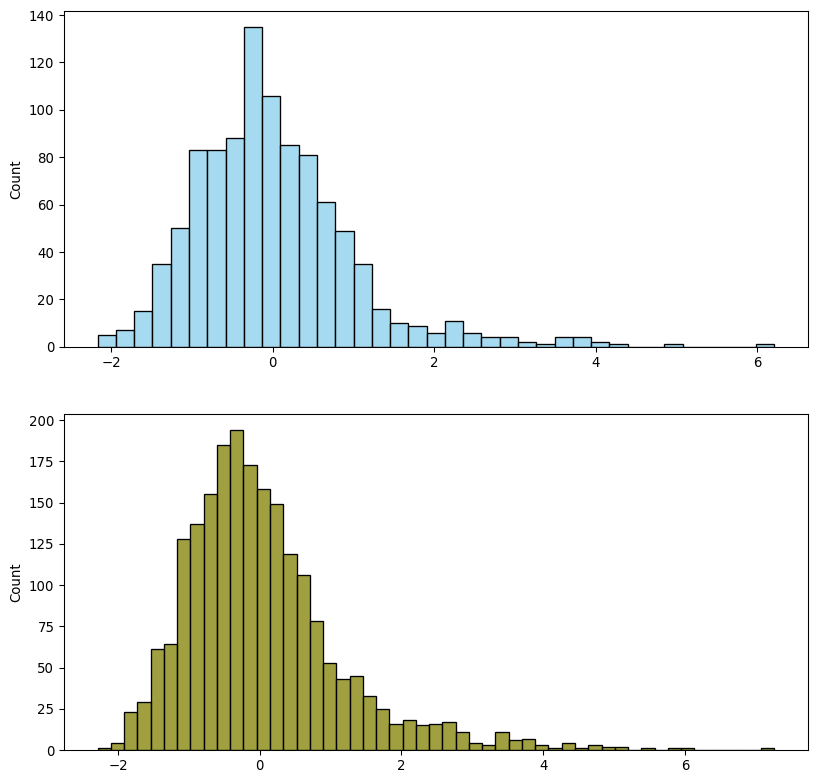

## 3.2 Normalisation

La **normalisation** est l’action de transformer les données de manière
à obtenir une norme ($\mathcal{l}_1$ ou $\mathcal{l}_2$) unitaire.
Autrement dit, avec la norme adéquate, la somme des éléments est égale à 1.
Par défaut, la norme est dans $\mathcal{l}_2$.
Cette transformation est particulièrement utilisée en classification de texte ou pour effectuer du *clustering*.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 4 : Normalisation</h3>

1.  Normaliser la variable `Median_Household_Income_2019` (ne pas écraser les valeurs !) et regarder l’histogramme avant/après normalisation.
2.  Vérifier que la norme $\mathcal{l}_2$ est bien égale à 1.

</div>

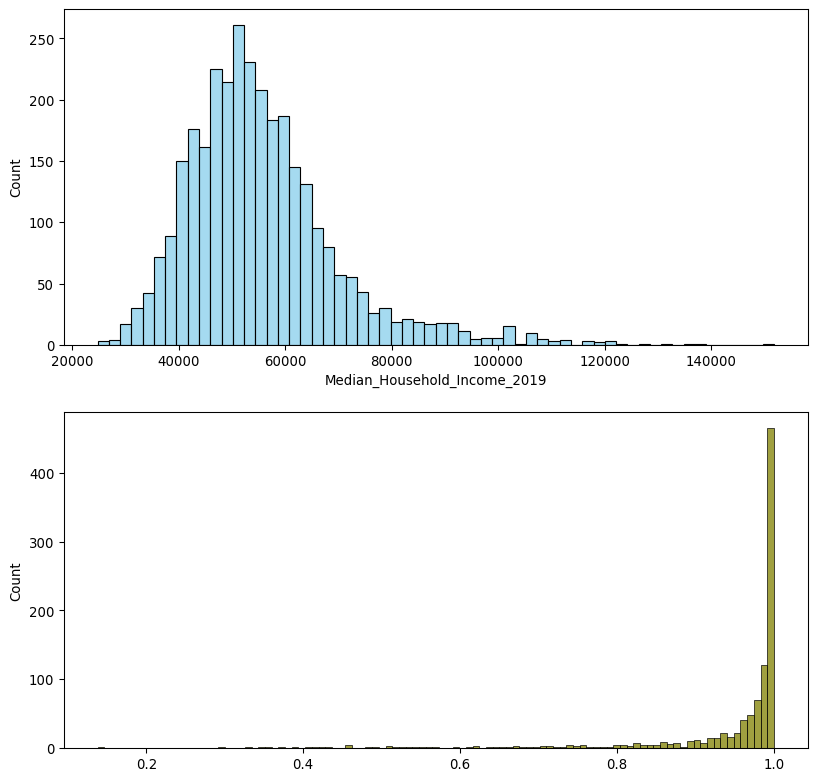

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## 3.3 Encodage des valeurs catégorielles

Les données catégorielles doivent être recodées
sous forme de valeurs numériques pour être intégrés aux modèles de *machine learning*.
Cela peut être fait de plusieurs manières :

-   `LabelEncoder`: transforme un vecteur `["a","b","c"]` en vecteur numérique `[0,1,2]`.
    Cette approche a l’inconvénient d’introduire un ordre dans les modalités, ce qui n’est pas toujours souhaitable

-   `OrdinalEncoder`: une version généralisée du `LabelEncoder` qui a vocation à s’appliquer sur des matrices ($X$),
    alors que `LabelEncoder` s’applique plutôt à un vecteur ($y$)

-   `pandas.get_dummies` effectue une opération de *dummy expansion*.
    Un vecteur de taille *n* avec *K* catégories sera transformé en matrice de taille $n \times K$
    pour lequel chaque colonne sera une variable *dummy* pour la modalité *k*.
    Il y a ici $K$ modalités et il y a donc multicolinéarité.
    Avec une régression linéaire avec constante,
    il convient de retirer une modalité avant l’estimation.

-   `OneHotEncoder` est une version généralisée (et optimisée) de la *dummy expansion*.
    Il a plutôt vocation à s’appliquer sur les *features* ($X$) du modèle

## 3.4 Imputation

Les données peuvent souvent contenir des valeurs manquantes, autrement dit des cases de notre *DataFrame* contenant un `NaN`.
Ces trous dans les données peuvent être à l’origine de *bugs* ou de mauvaises interprétations lorsque l’on passe à la modélisation.
Pour y remédier, une première approche peut être de retirer toutes les observations présentant un `NaN` dans au moins l’une des colonnes.
Cependant, si notre table contient beaucoup de `NaN`, ou bien que ces derniers sont répartis sur de nombreuses colonnes,
c’est aussi prendre le risque de retirer un nombre important de lignes, et avec cela de l’information importante pour un modèle car les valeurs manquantes sont rarement [réparties de manière aléatoire](https://stefvanbuuren.name/fimd/sec-MCAR.html).

Même si dans plusieurs situations, cette solution reste tout à fait viable, il existe une autre approche plus robuste appelée *imputation*.
Cette méthode consiste à remplacer les valeurs vides par une valeur donnée. Par exemple :

-   Imputation par la moyenne : remplacer tous les `NaN` dans une colonne par la valeur moyenne de la colonne ;
-   Imputation par la médiane sur le même principe, ou par la valeur de la colonne la plus fréquente pour les variables catégorielles ;
-   Imputation par régression : se servir d’autres variables pour essayer d’interpoler une valeur de remplacement adaptée.

Des méthodes plus complexes existent, mais dans de nombreux cas,
les approches ci-dessus peuvent suffire pour donner des résultats beaucoup plus satisfaisants.
Le package `Scikit` permet de faire de l’imputation de manière très simple ([documentation ici](https://scikit-learn.org/stable/modules/impute.html)).

## 3.5 Gestion des outliers

Les valeurs aberrantes (*outliers* en anglais) sont des observations qui se situent significativement à l’extérieur de la tendance générale des autres observations dans un ensemble de données. En d’autres termes, ce sont des points de données qui se démarquent de manière inhabituelle par rapport à la distribution globale des données.
Cela peut être dû à des erreurs de remplissage, des personnes ayant mal répondu à un questionnaire, ou
parfois simplement des valeurs extrêmes qui peuvent biaiser un modèle de façon trop importante.

A titre d’exemple, cela va être 3 individus mesurant plus de 4 mètres dans une population,
ou bien des revenus de ménage dépassant les 10M d’euros par mois sur l’échelle d’un pays, etc.

Une bonne pratique peut donc être de systématiquement regarder la distribution des variables à disposition,
pour se rendre compte si certaines valeurs s’éloignent de façon trop importante des autres.
Ces valeurs vont parfois nous intéresser, si par exemple on se concentre uniquement sur les très hauts revenus (top 0.1%)
en France. Cependant, ces données vont souvent nous gêner plus qu’autre chose, surtout si elles n’ont pas de sens dans le monde réel.

Si l’on estime que la présence de ces données extrêmes, ou *outliers*, dans notre base de données vont être problématiques plus qu’autre chose,
alors il est tout à fait entendable et possible de simplement les retirer.
La plupart du temps, on va se donner une proportion des données à retirer, par exemple 0.1%, 1% ou 5%,
puis retirer dans les deux queues de la distribution les valeurs extrêmes correspondantes.

Plusieurs packages permettent de faire ce type d’opérations, qui sont parfois plus complexes si on s’intéresse aux outlier sur plusieurs variables.
On pourra notamment citer la fonction `IsolationForest()` du package `sklearn.ensemble`.

<br>

Pour plus de détails sur ces deux derniers points, il est recommandé d’aller voir l’exemple *Pour aller plus loin* en bas de la page.

<div class="alert alert-success" role="alert">
<h3 class="alert-heading"><i class="fa-solid fa-pencil"></i> Exercice 5 : Encoder des variables catégorielles</h3>

1.  Créer `df` qui conserve uniquement les variables `state_name` et `county_name` dans `votes`.

2.  Appliquer à `state_name` un `LabelEncoder`
    *Note : Le résultat du label encoding est relativement intuitif, notamment quand on le met en relation avec le vecteur initial.*

3.  Regarder la *dummy expansion* de `state_name`

4.  Appliquer un `OrdinalEncoder` à `df[['state_name', 'county_name']]`
    *Note : Le résultat du *ordinal encoding* est cohérent avec celui du label encoding*

5.  Appliquer un `OneHotEncoder` à `df[['state_name', 'county_name']]`

*Note : `scikit` optimise l’objet nécessaire pour stocker le résultat d’un modèle de transformation. Par exemple, le résultat de l’encoding One Hot est un objet très volumineux. Dans ce cas, `scikit` utilise une matrice Sparse.*

</div>

array([[23, 'Missouri'],
       [25, 'Nebraska'],
       [30, 'New York'],
       ...,
       [41, 'Texas'],
       [41, 'Texas'],
       [41, 'Texas']], dtype=object)

3107 rows × 49 columns

array([23., 25., 30., ..., 41., 41., 41.])

<3107x1891 sparse matrix of type '<class 'numpy.float64'>'
    with 6214 stored elements in Compressed Sparse Row format>

# 4. Pour aller plus loin : un exemple pratique

Pour faire vos premiers pas en modélisation, notamment sur le preprocessing de données, vous pouvez également consulter le sujet 3 d’un hackathon organisé par l’Insee en 2023, *Explorer les habitudes alimentaires de nos compatriotes*, sur le [SSP Cloud](https://www.sspcloud.fr/formation?search=funath&path=%5B%22Funathon%202023%22%5D) ou sur [Github](https://github.com/InseeFrLab/funathon2023_sujet3/).

Le but du sujet est de travailler sur les données de consommations et habitudes alimentaires de l’étude INCA 3. Vous y travaillerez plusieurs thèmes :

-   Analyse exploratoire de données et visualisations
-   Clustering d’individus : du preprocessing jusqu’aux méthodes classiques d’apprentissage non supervisé (ACP, K-moyennes, Clustering Ascendant Hiérarchique)
-   Prédiction de l’IMC : Premiers pas vers les méthodes d’apprentissage supervisé et les *preprocessings* associés

# 5. Références

Insee. 2018. “Guide de Sémiologie Cartographique.”